In [13]:
import numpy as np
import cv2
from PIL import Image
import argparse
import os, sys
from tqdm import tqdm
from os.path import join, split, splitext, abspath, isfile
sys.path.insert(0, abspath(".."))
sys.path.insert(0, abspath("."))

from pathlib import Path
from skimage.measure import label, regionprops
from src.utils import Line, LineAnnotation, line2hough
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from src.utils import reverse_mapping, visulize_mapping_orig
from src.transforms import get_transformations

In [9]:
def nearest8(x):
    return int(np.round(x/8)*8)


def vis_anno(image, annotation):
    mask = annotation.oriental_mask()
    mask_sum = mask.sum(axis=0).astype(bool)
    image_cp = image.copy()
    image_cp[mask_sum, ...] = [0, 255, 0]
    mask = np.zeros((image.shape[0], image.shape[1]))
    mask[mask_sum] = 1
    return image_cp, mask


def get_lines_from_txt(label_file):
    lines = []
    with open(label_file) as f:
        data = f.readlines()
        for line in data:
            data1 = line.strip().split(',')
            if len(data1) <= 3:
                continue
            data1 = [int(float(x)) for x in data1 if x!=''] # x1, y1, x2, y2
            if data1[1]==data1[3] and data1[0]==data1[2]:
                continue
            lines.append([data1[1], data1[0], data1[3], data1[2]]) # y1, x1, y2, x2
    return lines


def show_image(image):
    fig, ax = plt.subplots(1, figsize=(50, 30))
    ax.imshow(image)
    plt.show()

    
def visualize_data(label_file):
    print(label_file)
    
    lines = get_lines_from_txt(label_file, for_viz=True)
    image_path = label_file.with_suffix('.jpeg')
    if isfile(image_path):
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        H, W, _ = image.shape
    else:
        print(f"Warning: image {image_path} doesnt exist!")
        return
    
    for line in lines:
        y1, x1, y2, x2 = line
        cv2.line(image, (x1,y1), (x2,y2), (0, 255, 0), 2)
    
    show_image(image)

    
def get_annotation(image_size, lines, num_directions):
    H, W, _ = image_size
    lines = [Line(l) for l in lines]

    return LineAnnotation(size=[H, W], divisions=num_directions, lines=lines)


def lines_to_keypoints(lines):
    keypoints = []
    line_indexes = []

    for l_idx, l in enumerate(lines):
        keypoints.append((l[0], l[1]))
        keypoints.append((l[2], l[3]))
        line_indexes.append(l_idx)
        line_indexes.append(l_idx)
    
    return keypoints, line_indexes


def keypoints_to_lines(keypoints, line_indexes):
    lines = []
    line_indexes = np.array(line_indexes)
    line_indexes_unique = np.unique(line_indexes)
    keypoints = np.array(keypoints)

    for li in line_indexes_unique:
        line_keypoints = keypoints[line_indexes==li, :]

        if line_keypoints[0][1] >= line_keypoints[1][1]:
            lines.append(list(line_keypoints[1])+list(line_keypoints[0]))
        else:
            lines.append(list(line_keypoints[0])+list(line_keypoints[1]))
    return lines


def prepare_data(label_file, transform=None, 
                             num_directions=12,
                             numangle=100,
                             numrho=100,
                             ext='.jpeg'):

    image_path = label_file.with_suffix(ext)

    im = cv2.imread(str(image_path))
    image_size = im.shape
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    lines = get_lines_from_txt(label_file)

    if transform is not None:
        keypoints, line_idxs = lines_to_keypoints(lines)
        transformed = transform(image=im, keypoints=keypoints, line_idxs=line_idxs)
        im = transformed['image']
        transformed_keypoints = transformed['keypoints']
        transformed_line_idxs = transformed['line_idxs']
        lines = keypoints_to_lines(transformed_keypoints, transformed_line_idxs)

    annotation = get_annotation(image_size, lines, num_directions)
    
    _, newH, newW = im.shape
    hough_space_label = np.zeros((numangle, numrho))

    for l in annotation.lines:
        theta, r = line2hough(l, numAngle=numangle, numRho=numrho, size=(newH, newW))
        hough_space_label[theta, r] += 1

    hough_space_label = cv2.GaussianBlur(hough_space_label, (5,5), 0)

    if hough_space_label.max() > 0:
        hough_space_label = hough_space_label / hough_space_label.max()

    gt_coords = [l.coord for l in annotation.lines]

    data = dict({
        "hough_space_label8": hough_space_label,
        "coords": np.array(gt_coords)
    })

    return im, data

def show_image(img):
    fig, ax = plt.subplots(1, figsize=(25, 15))

    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


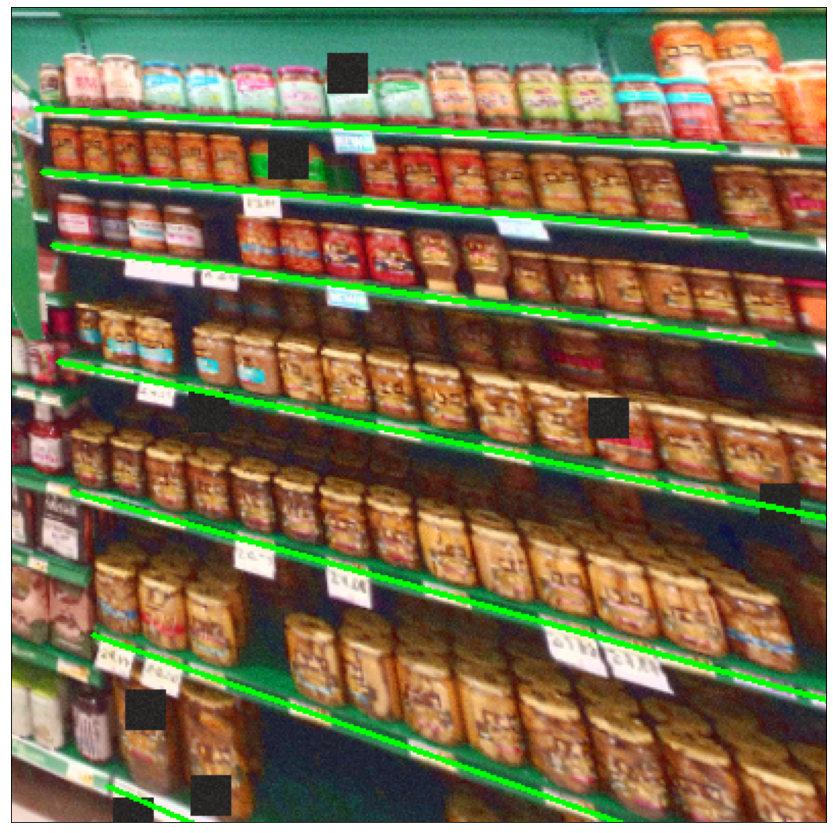

In [46]:
data_dir = Path('/home/rauf/datasets/retechlabs/shelves_detection/harr/gts/')

numangle=100 
numrho=100
num_directions=12

labels_files = list(data_dir.glob('*.txt'))
label_file = labels_files[0]

transform = A.Compose([
            A.Resize(400, 400),
            A.HorizontalFlip(p=0.5),
            A.Rotate(p=0.1, limit=(-30, 30), interpolation=0, border_mode=2),
            A.IAAPerspective (scale=(0.05, 0.1), keep_size=True, p=1),
            A.RandomBrightnessContrast(p=0.3, 
                                       brightness_limit=(-0.15, 0.15), 
                                       contrast_limit=(-0.15, 0.15)),
            A.Blur(p=0.3, 
                   blur_limit=(3, 7)),
            A.Cutout(p=0.5, 
                     num_holes=8, 
                     max_h_size=20, 
                     max_w_size=20),
            A.HueSaturationValue(p=0.3, 
                                 hue_shift_limit=(-20, 20), 
                                 sat_shift_limit=(-30, 30), 
                                 val_shift_limit=(-20, 20)),
            A.GaussNoise(var_limit=5. / 255., p=0.05),
            A.ISONoise(p=0.2, 
                       intensity=(0.1, 0.5), 
                       color_shift=(0.01, 0.05)),
            A.MotionBlur(p=0.1, 
                         blur_limit=(3, 7)),
            A.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='yx', 
                                            remove_invisible=False,
                                            label_fields=['line_idxs']))

im, data = prepare_data(label_file, transform=transform,
                         num_directions=num_directions,
                         numangle=numangle,
                         numrho=numrho)
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
image = unorm(im).numpy().transpose(1, 2, 0)

lines = data['coords']

for line in lines:
    y1, x1, y2, x2 = [int(x) for x in line]
    cv2.line(image, (x1,y1), (x2,y2), (0, 255, 0), 2)
    
show_image(image)

In [12]:
data

{'hough_space_label8': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'coords': array([[127.19017312,   4.71657224,  43.25748697, 305.25818498],
        [160.66273756,  17.70945703,  78.12667784, 311.63927355],
        [196.85755461,  32.40667312, 116.66709384, 318.88714118],
        [251.02674495,  49.82494583, 171.02073224, 333.75035246],
        [303.11456195,  69.96521623, 224.86407455, 344.08581169],
        [352.06940206,  91.03147222, 276.68888586, 354.28069052],
        [398.86920971, 107.94300598, 325.04181583, 364.760354  ]])}